# Lane Detection

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


#get roi trapezoid for lanes bounderies
def region_of_interest(img):

    mask = np.zeros_like(img)   
    
    xsize = img.shape[1]
    ysize = img.shape[0]
    
    poly_left_bottom = (xsize*5/100, ysize*80/100)
    poly_left_top = (xsize * 49/100 , ysize * 58/100)
    poly_right_bottom = (xsize * 95/100 , ysize*80/100)
    poly_right_top = (xsize * 51/100  , ysize*58/100)
    
    vertices = np.array([[poly_left_bottom, poly_left_top, poly_right_top, poly_right_bottom]], dtype=np.int32)
#     print(vertices)
  
    ignore_mask_color = 1
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
 
def get_full_lines(roi,lines,color, thickness):
    leftline = []
    rightline = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < 0:
                if not leftline:
                    if x1 < x2:
                        leftline = [x1,y1,x2,y2]
                    else:
                        leftline = [x2,y2,x1,y1]
                else:
                    if x1 < leftline[0]:
                        leftline[0] = x1
                        leftline[1] = y1
                    if x1 > leftline[2]:
                        leftline[2] = x1
                        leftline[3] = y1
                    if x2 < leftline[0]:
                        leftline[0] = x2
                        leftline[1] = y2
                    if x2 > leftline[2]:
                        leftline[2] = x2
                        leftline[3] = y2                                            

            if slope > 0:
                if not rightline:
                    if x1 < x2:
                        rightline = [x1,y1,x2,y2]
                    else:
                        rightline = [x2,y2,x1,y1]
                else:
                    if x1 < rightline[0]:
                        rightline[0] = x1
                        rightline[1] = y1
                    if x1 > rightline[2]:
                        rightline[2] = x1
                        rightline[3] = y1

                    if x2 < rightline[0]:
                        rightline[0] = x2
                        rightline[1] = y2
                    if x2 > rightline[2]:
                        rightline[2] = x2
                        rightline[3] = y2
                        
    height, width = roi.shape
#     print(height,width)
    if leftline:
        leftslope = (leftline[3] - leftline[1])/(leftline[2]- leftline[0])
        yintercept = (leftline[3] - leftslope*leftline[2])
        x3 = (height - yintercept)/leftslope
        leftline = (int(x3), height ,  leftline[2], leftline[3])
    if rightline:
        rightslope = (rightline[3] - rightline[1])/(rightline[2]- rightline[0])
        yintercept = (rightline[3] - rightslope*rightline[2])
        x3 = (height - yintercept)/rightslope        
        rightline = (rightline[0], rightline[1] ,  int(x3), height)
    return leftline,rightline

In [2]:
def process_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(gray, 60, 130)
    roi = region_of_interest(edges)
    plt.imshow(roi)
    plt.figure()
    lines = cv2.HoughLinesP(roi, 2, np.pi / 180, 50, np.array([]), minLineLength=20, maxLineGap=200)
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    if type(lines) is not type(None):
        left_line, right_line = get_full_lines(roi,lines,(255,0,0),5)
        for line in [[left_line],[right_line]]:
             if len(line[0]):
                for x1,y1,x2,y2 in line:
                    cv2.line(line_img, (x1, y1), (x2, y2),[255, 0, 0],6)
    return cv2.addWeighted(image, 0.8, line_img, 1., 0.)

In [3]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

t:   2%|▏         | 5/300 [00:00<00:05, 49.19it/s, now=None]

Moviepy - Building video driving_with_lanes_marked.mp4.
Moviepy - Writing video driving_with_lanes_marked.mp4



Moviepy - Done !
Moviepy - video ready driving_with_lanes_marked.mp4
CPU times: user 7.31 s, sys: 251 ms, total: 7.56 s
Wall time: 7.86 s


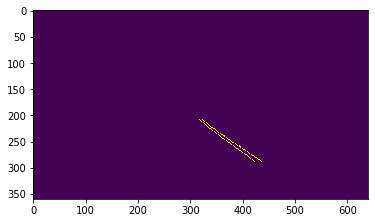

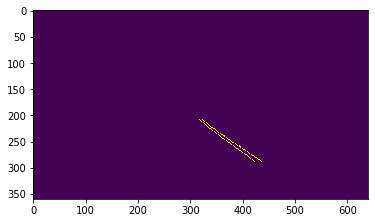

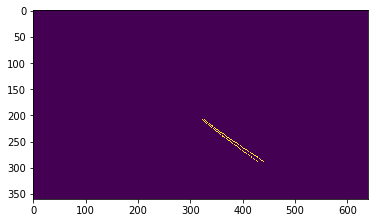

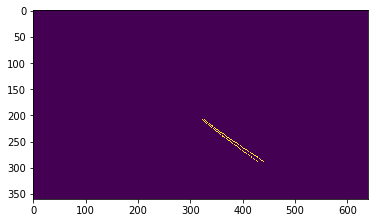

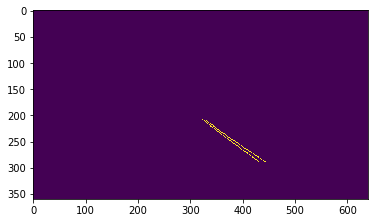

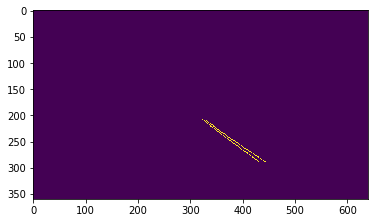

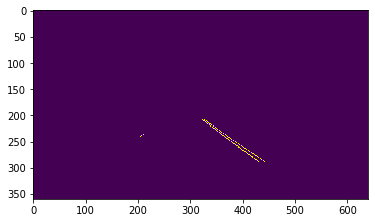

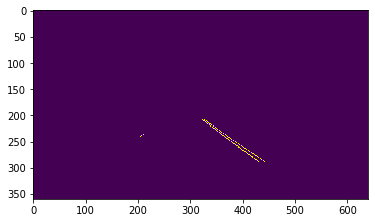

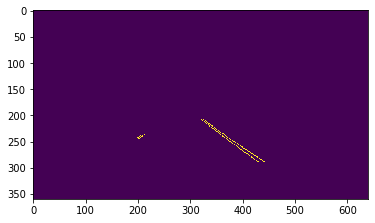

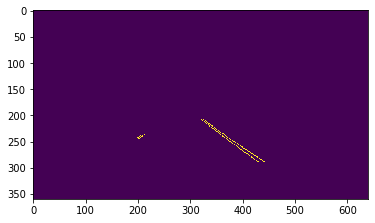

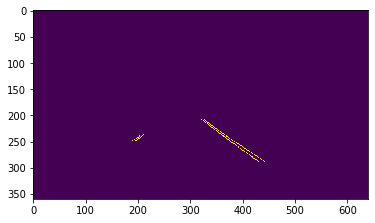

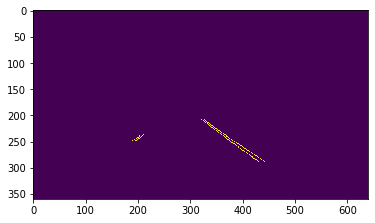

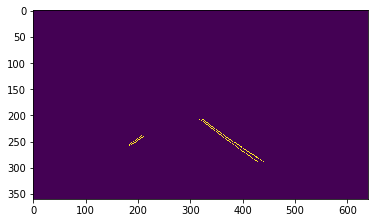

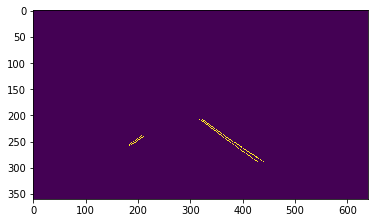

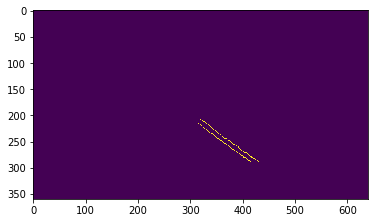

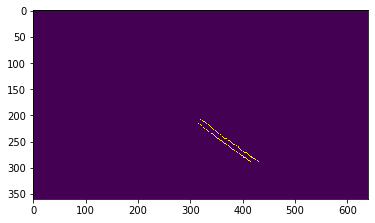

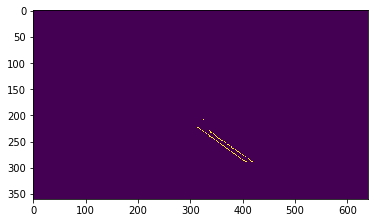

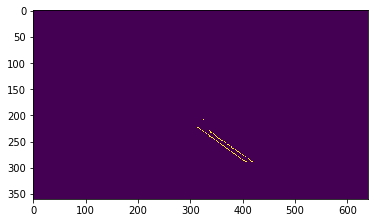

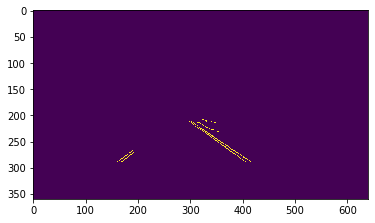

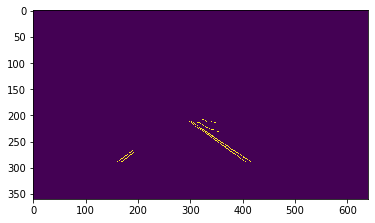

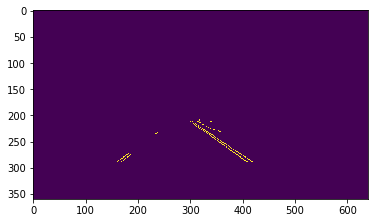

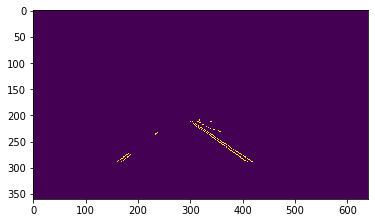

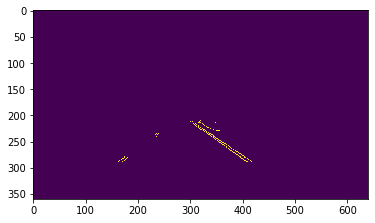

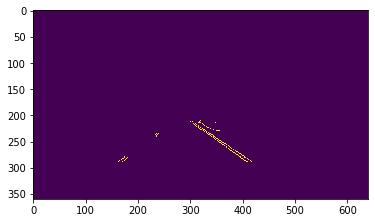

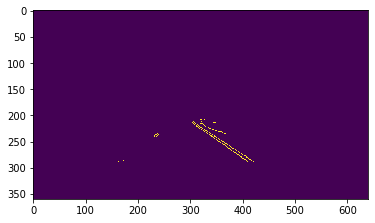

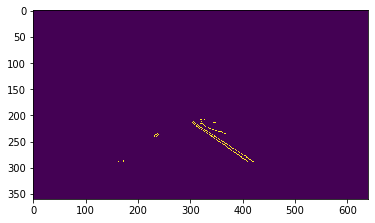

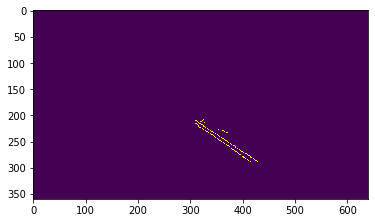

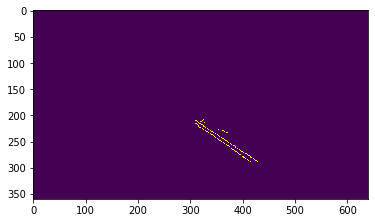

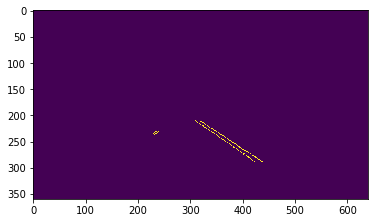

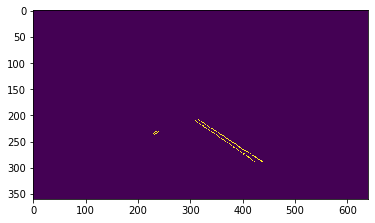

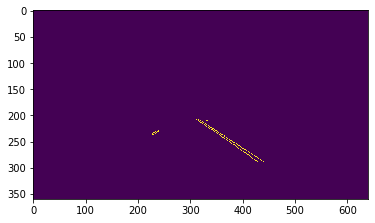

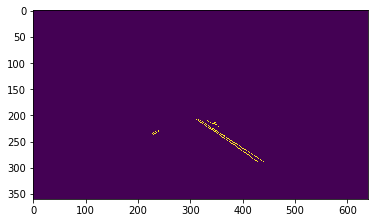

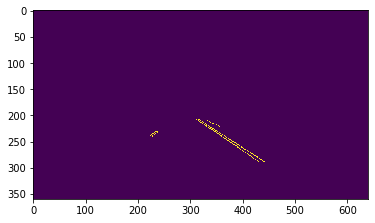

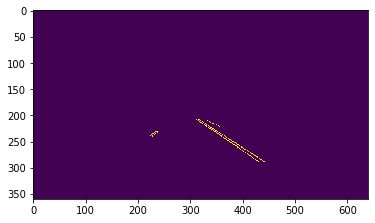

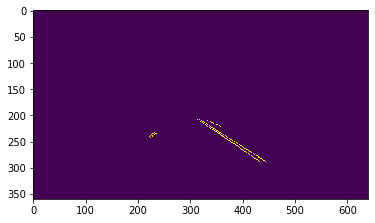

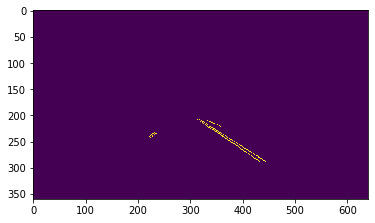

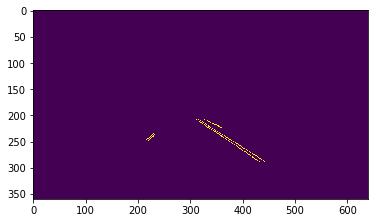

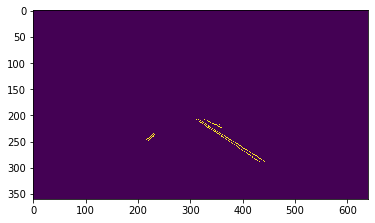

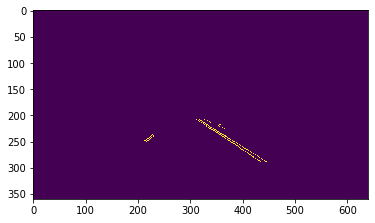

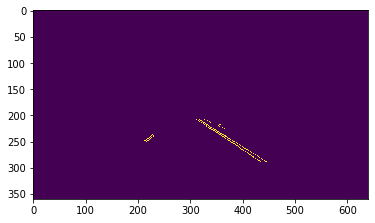

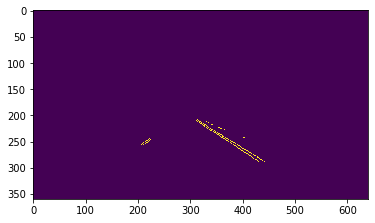

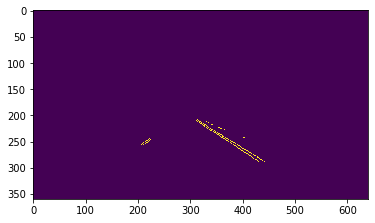

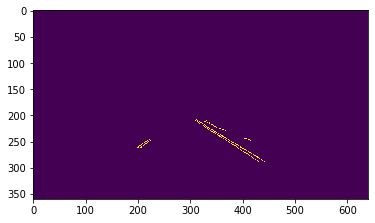

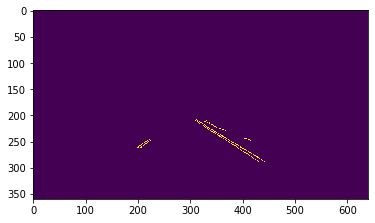

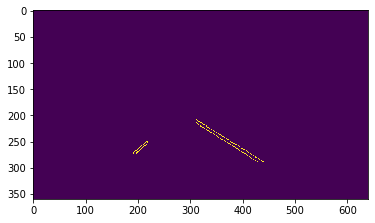

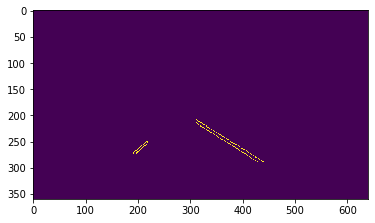

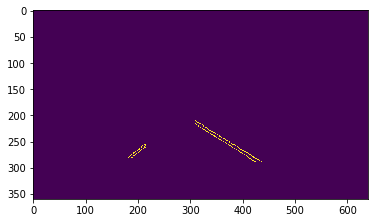

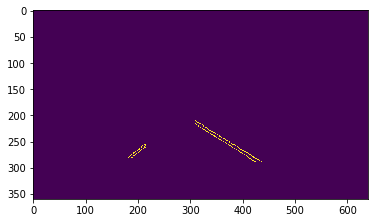

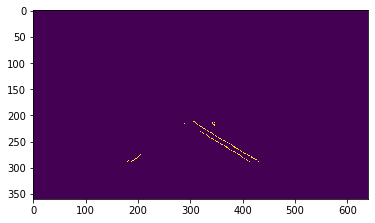

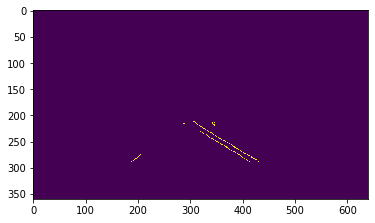

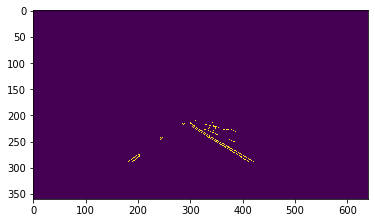

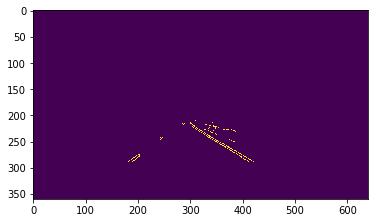

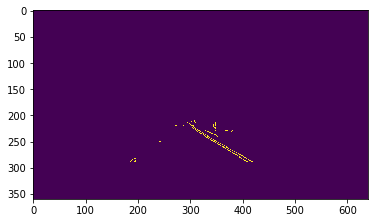

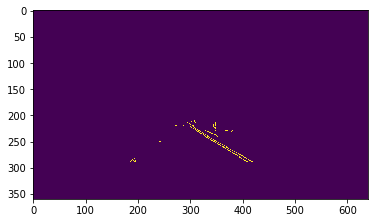

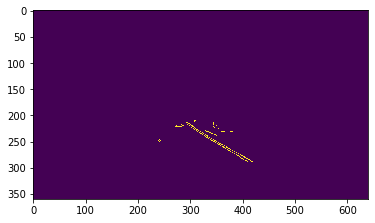

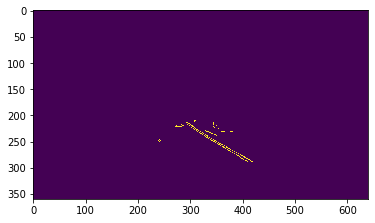

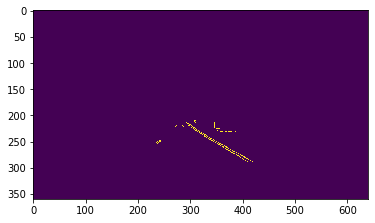

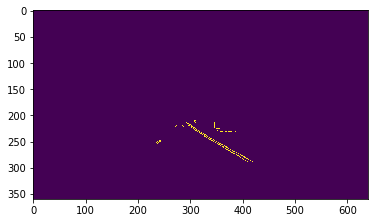

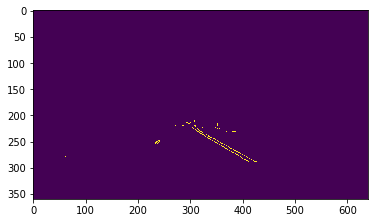

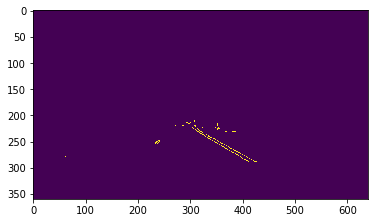

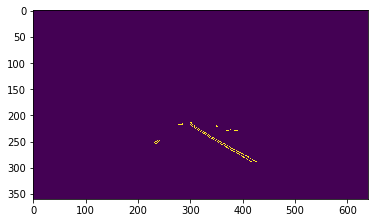

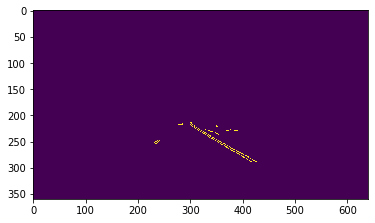

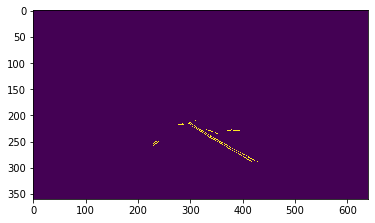

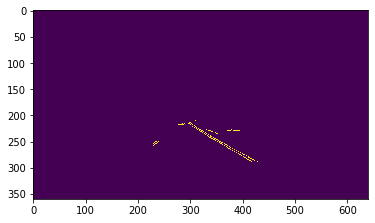

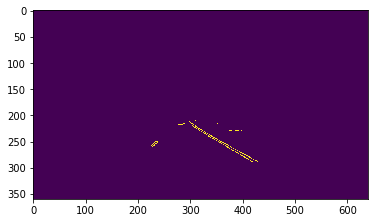

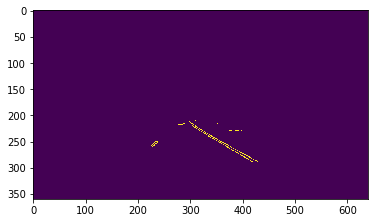

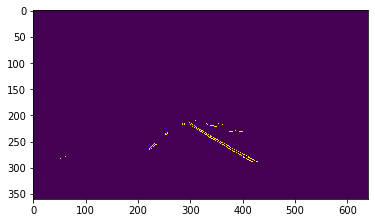

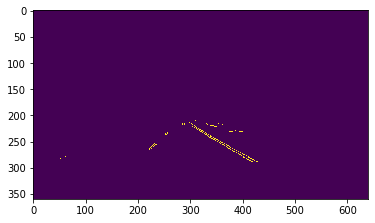

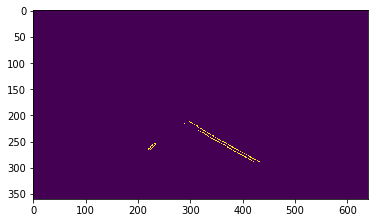

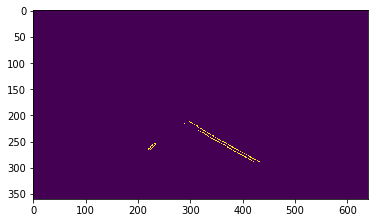

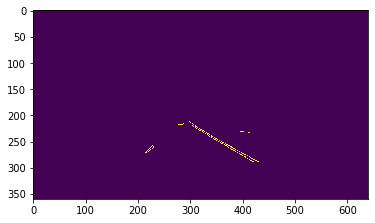

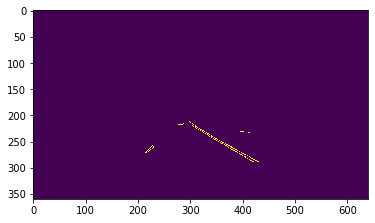

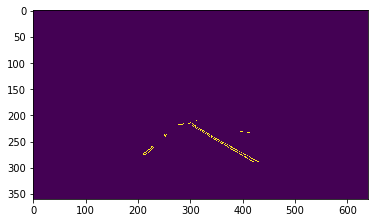

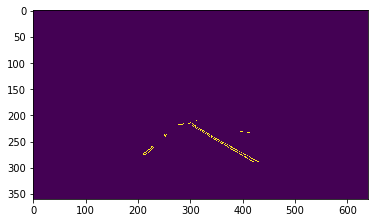

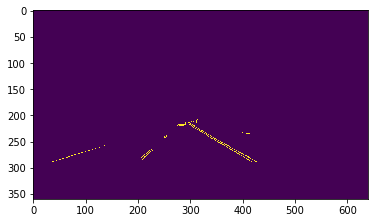

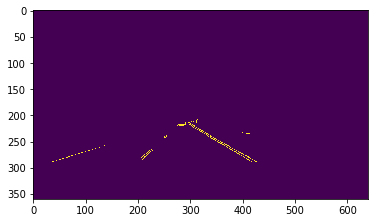

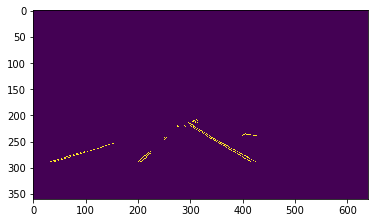

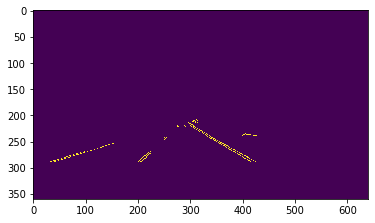

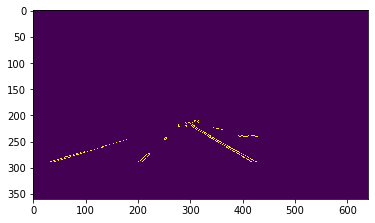

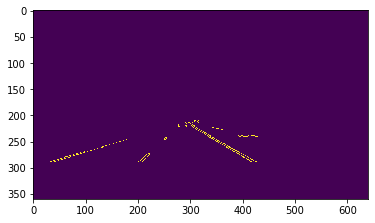

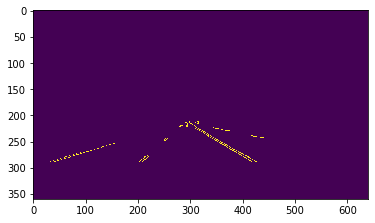

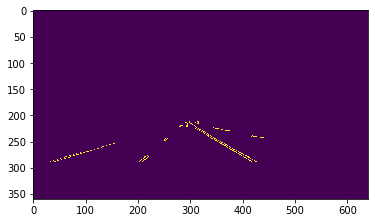

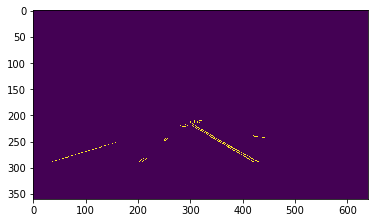

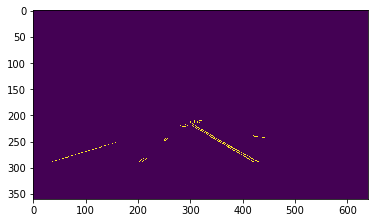

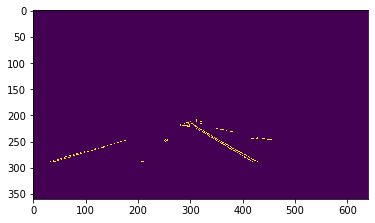

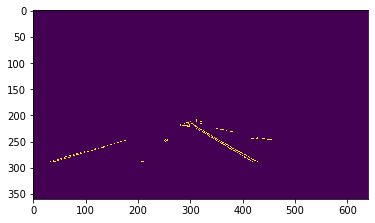

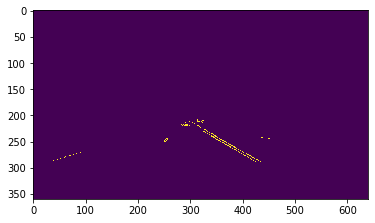

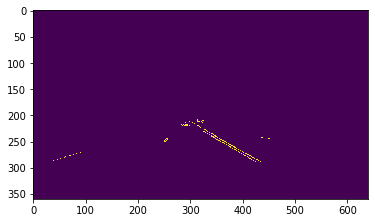

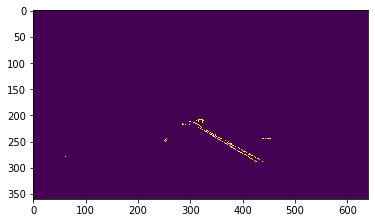

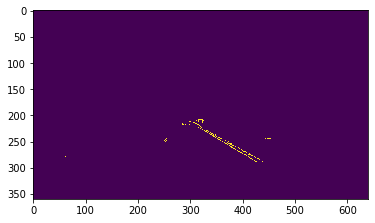

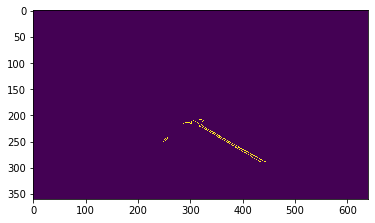

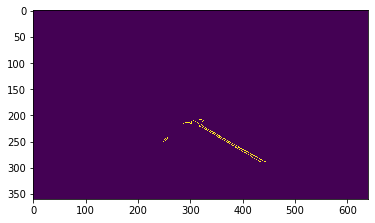

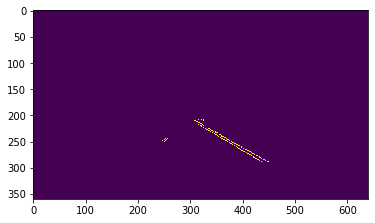

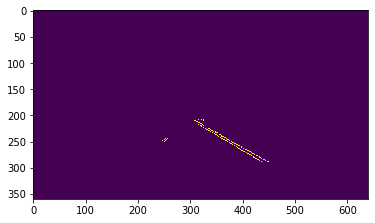

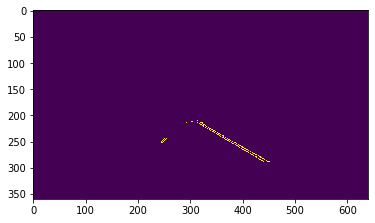

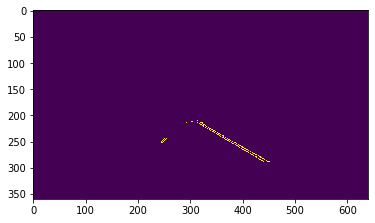

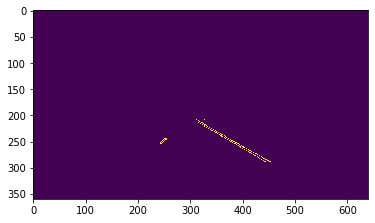

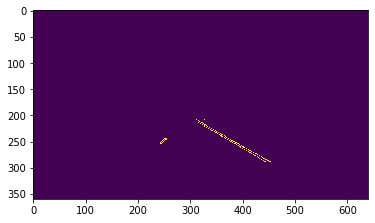

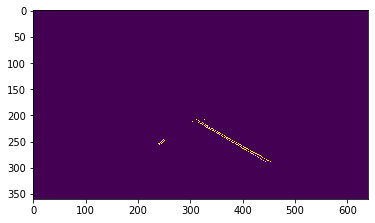

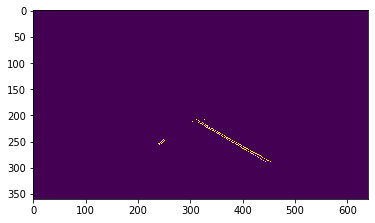

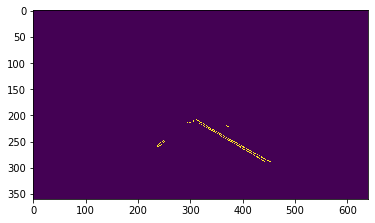

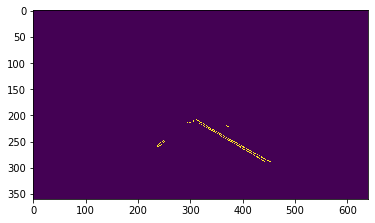

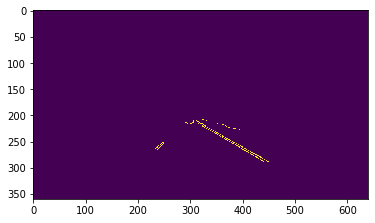

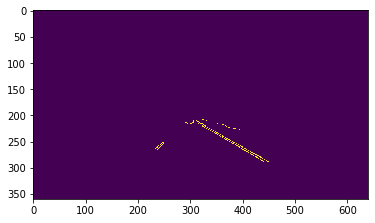

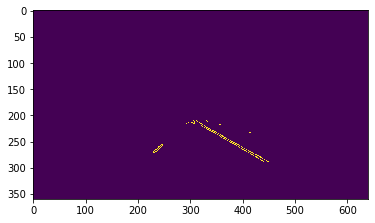

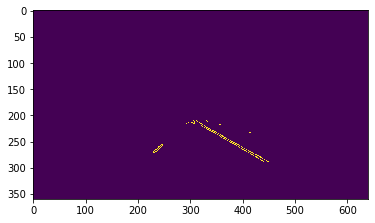

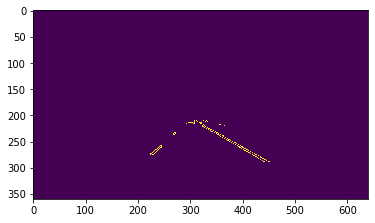

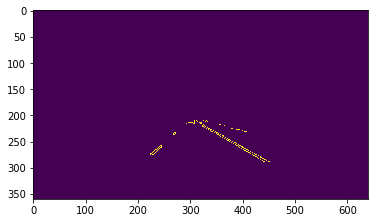

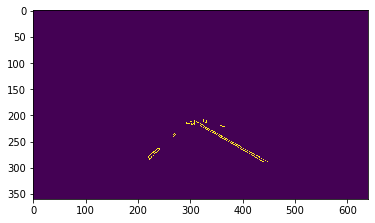

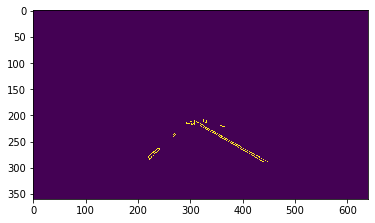

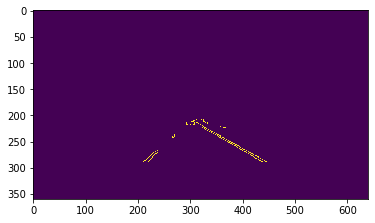

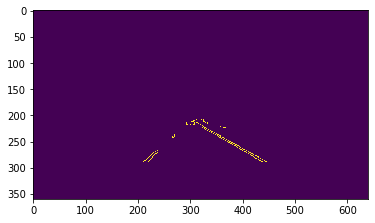

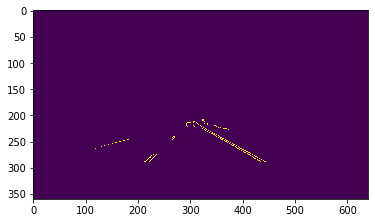

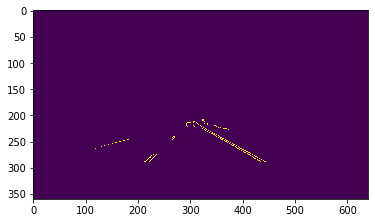

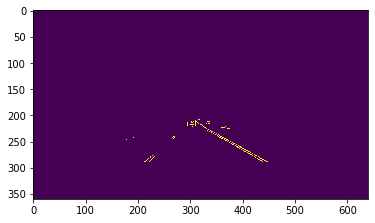

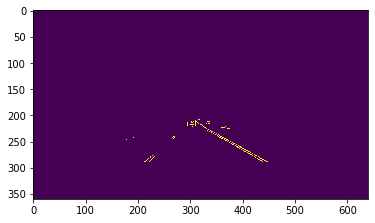

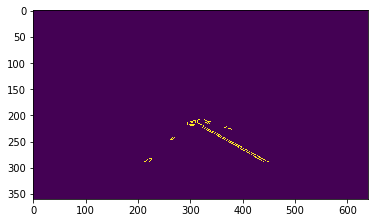

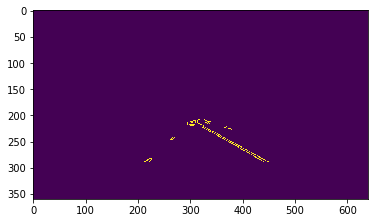

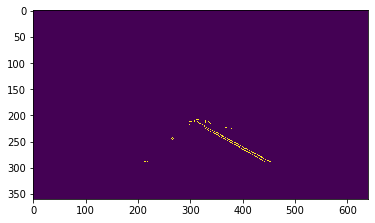

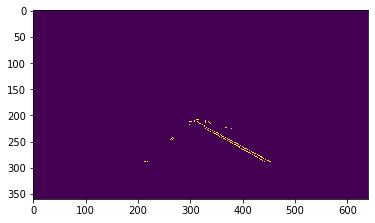

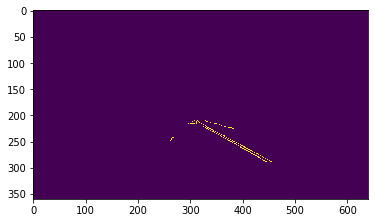

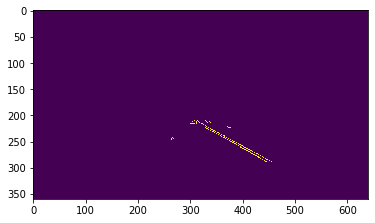

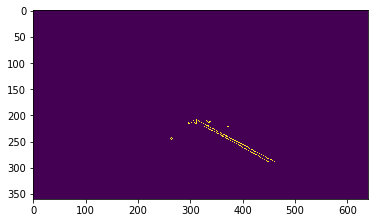

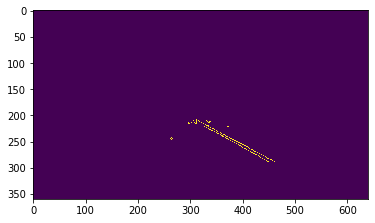

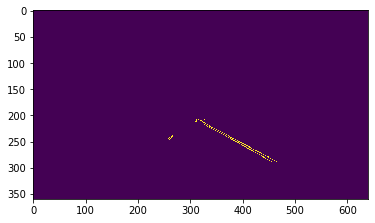

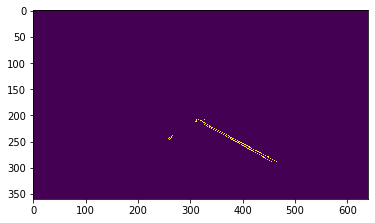

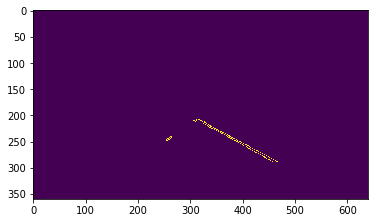

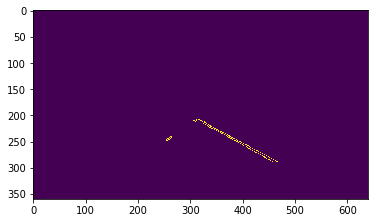

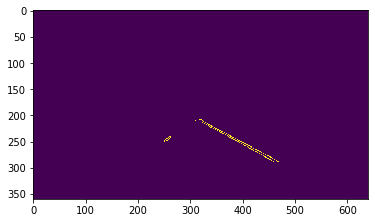

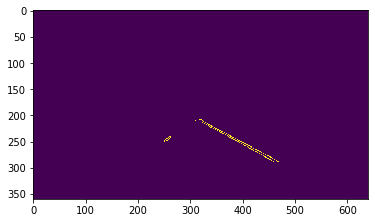

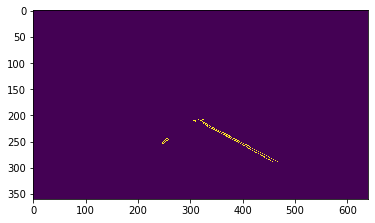

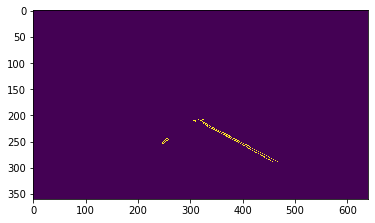

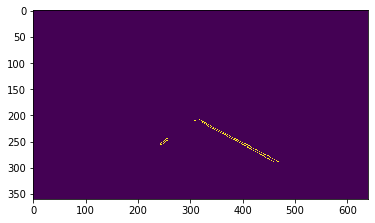

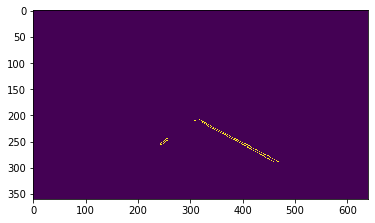

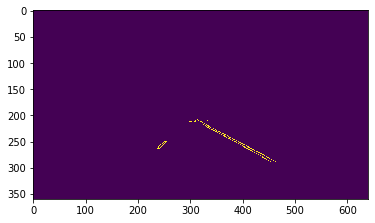

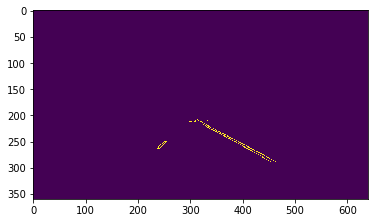

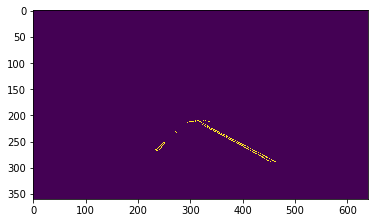

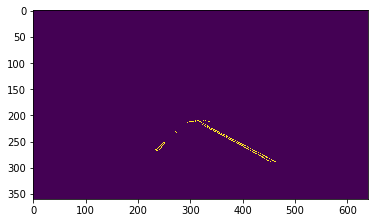

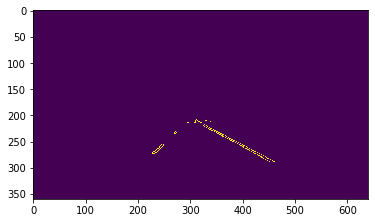

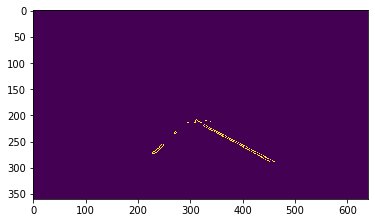

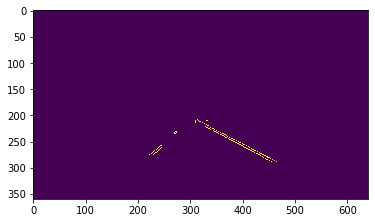

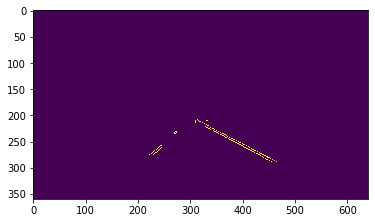

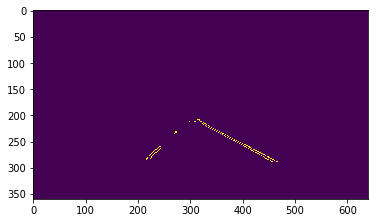

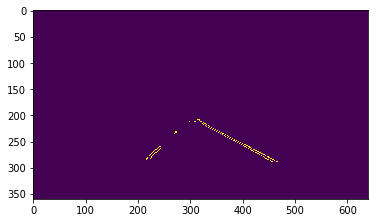

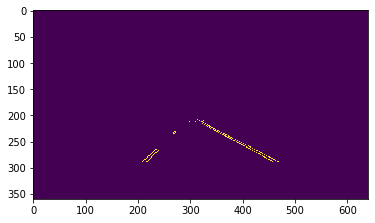

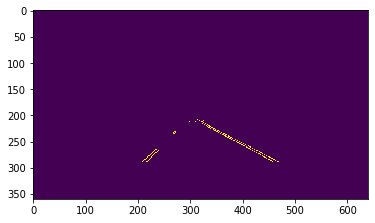

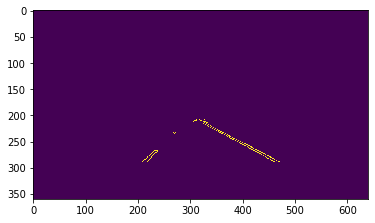

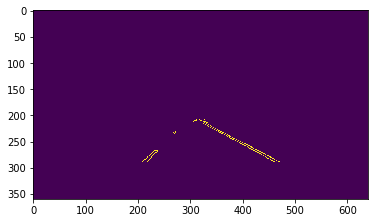

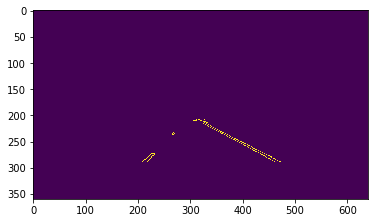

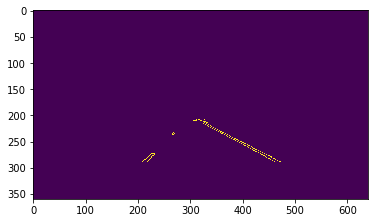

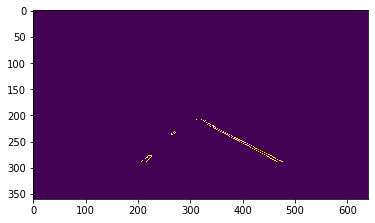

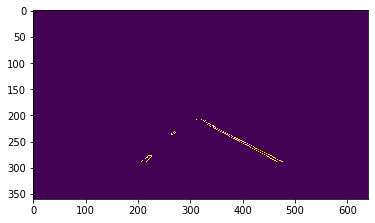

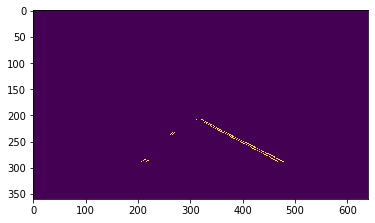

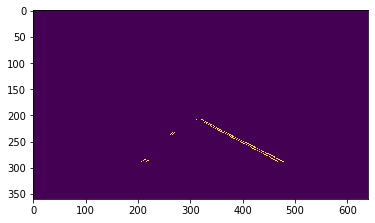

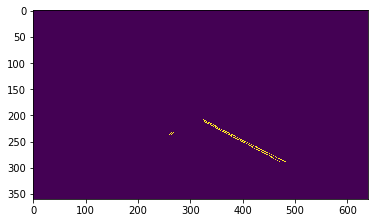

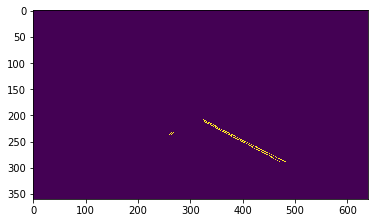

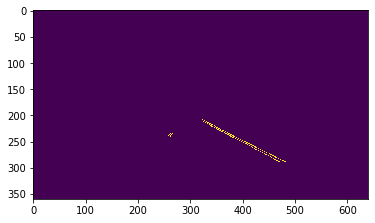

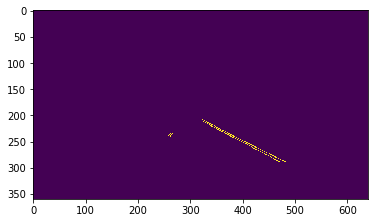

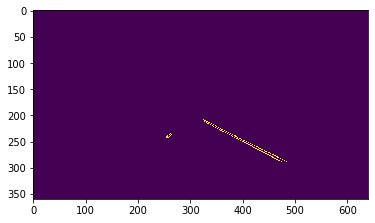

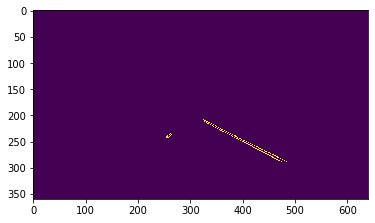

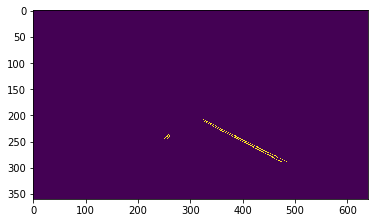

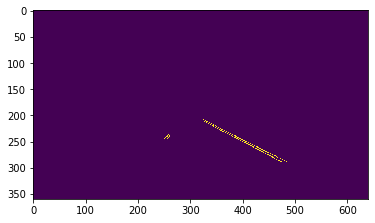

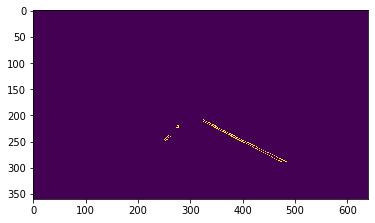

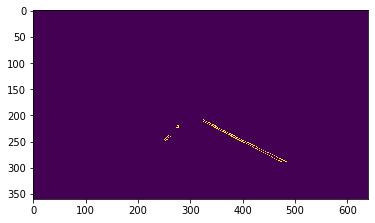

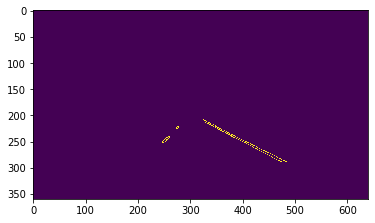

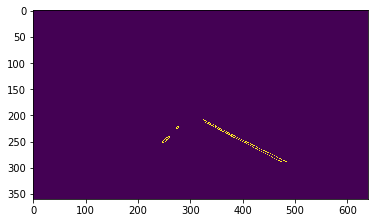

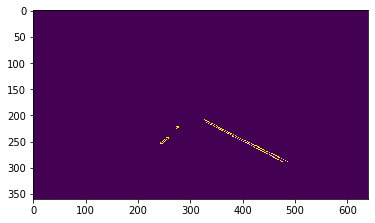

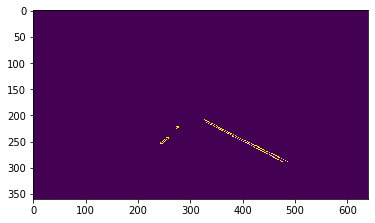

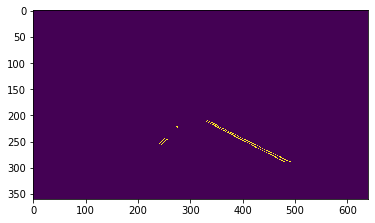

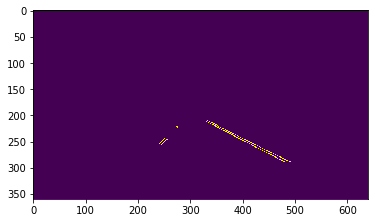

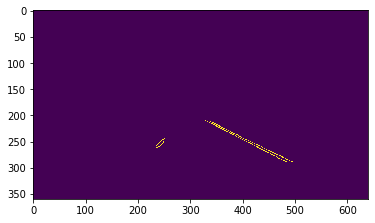

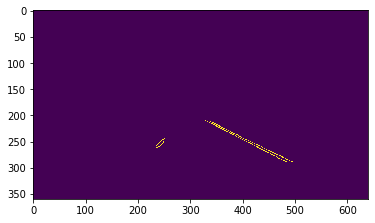

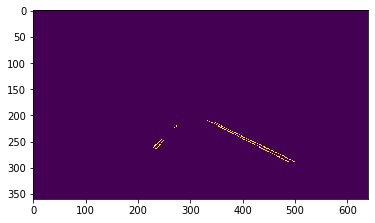

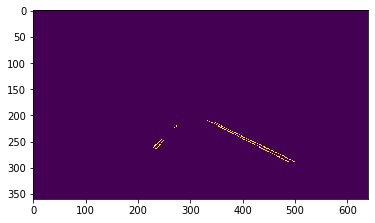

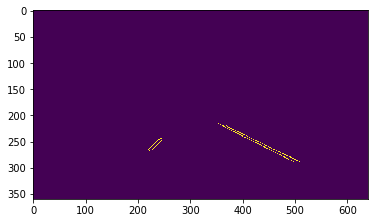

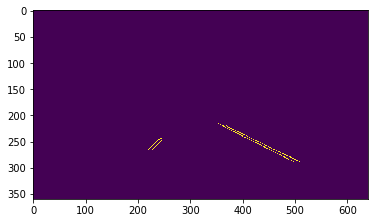

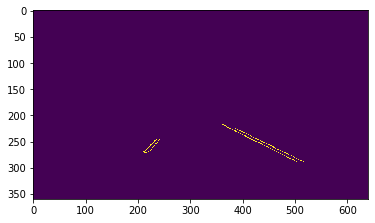

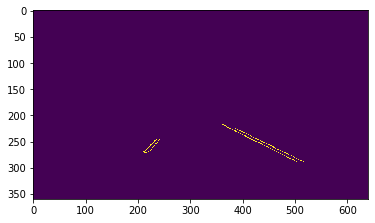

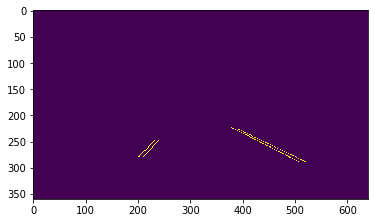

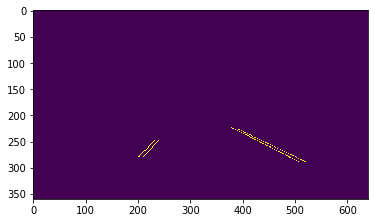

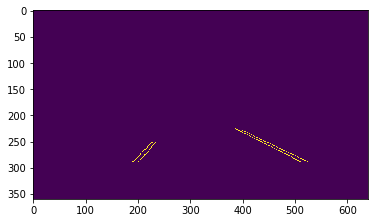

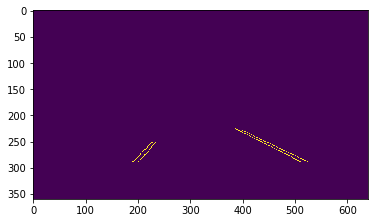

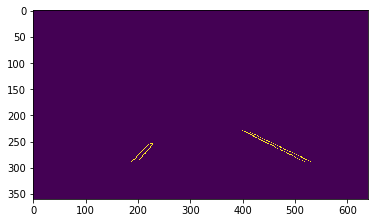

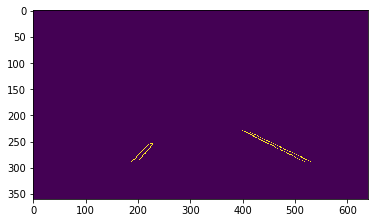

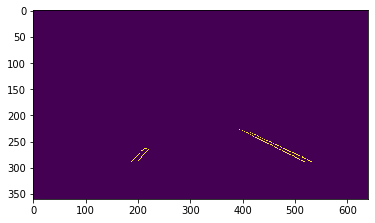

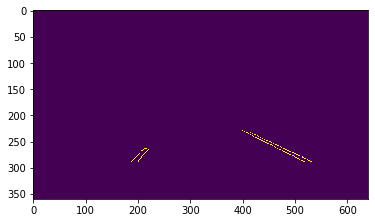

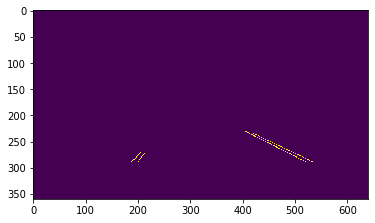

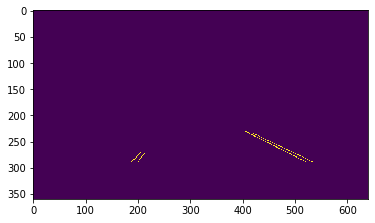

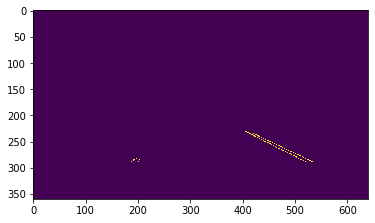

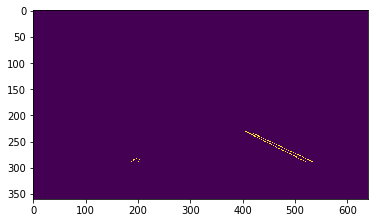

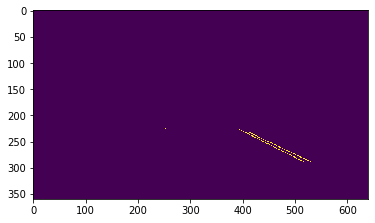

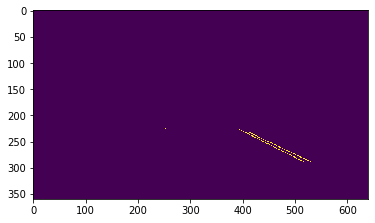

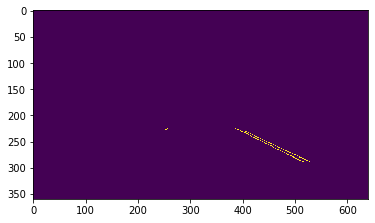

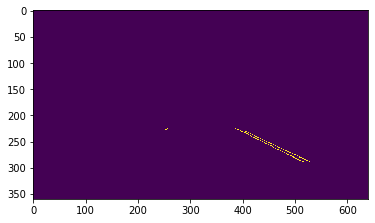

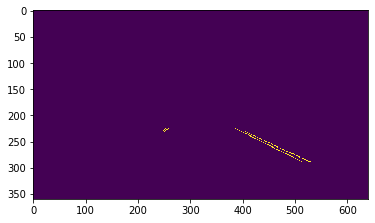

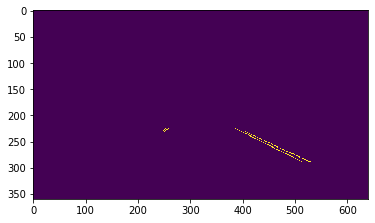

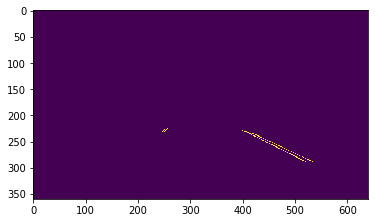

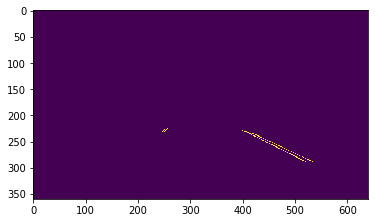

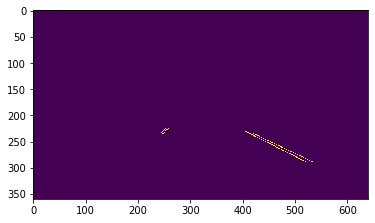

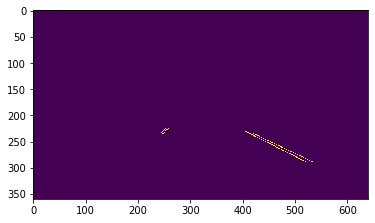

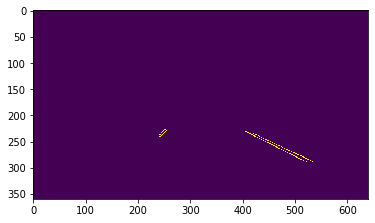

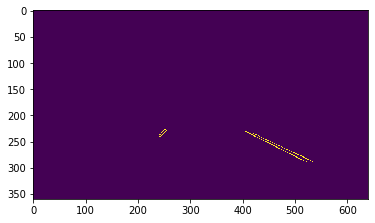

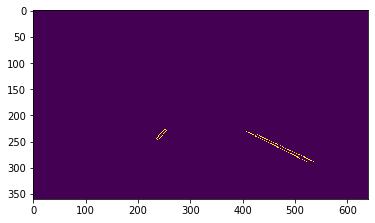

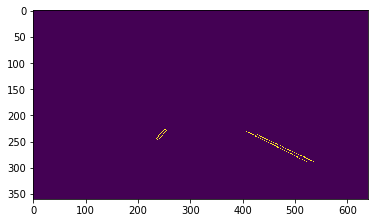

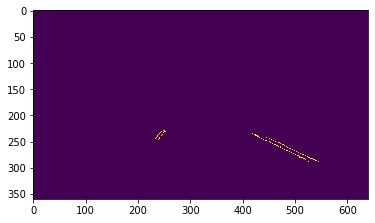

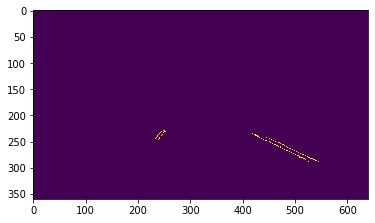

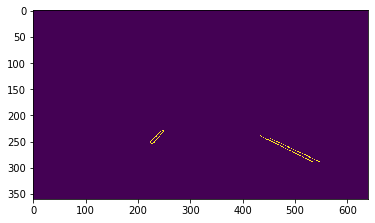

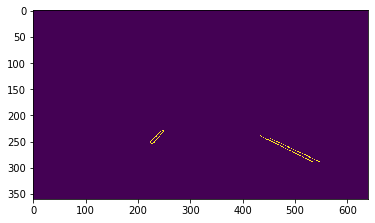

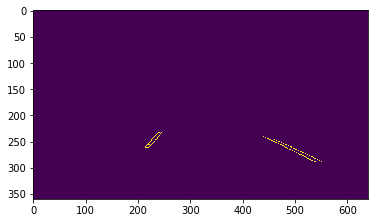

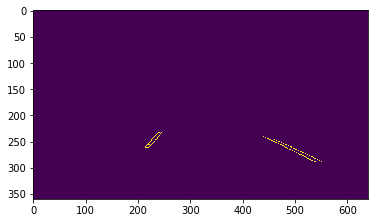

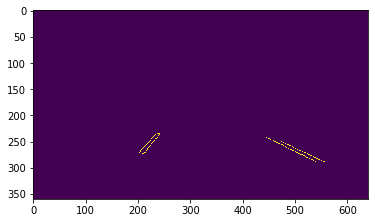

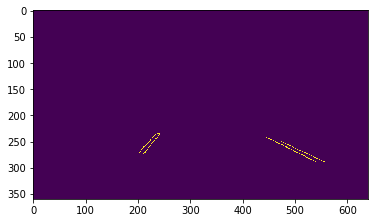

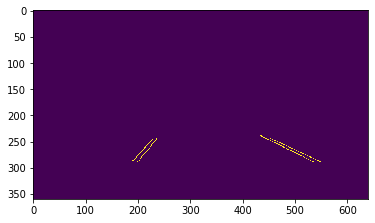

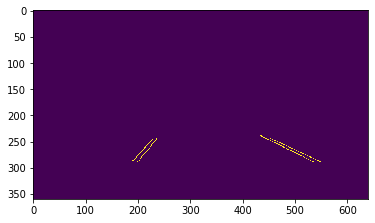

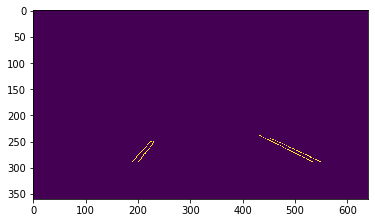

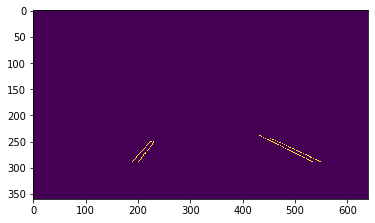

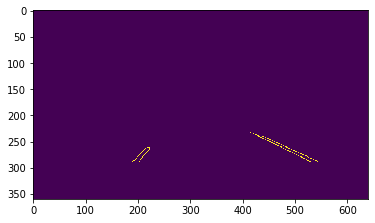

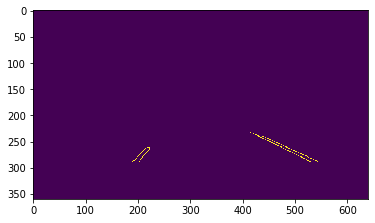

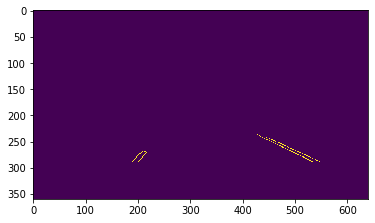

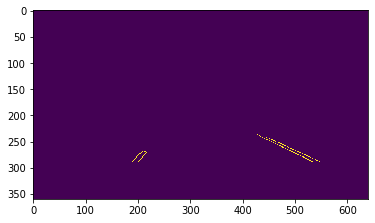

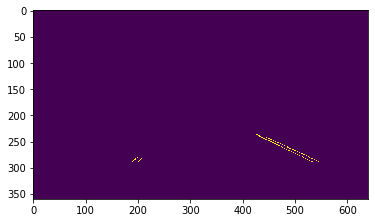

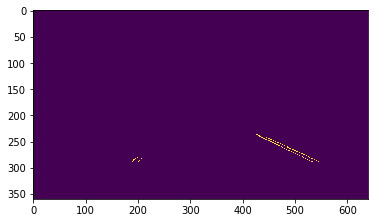

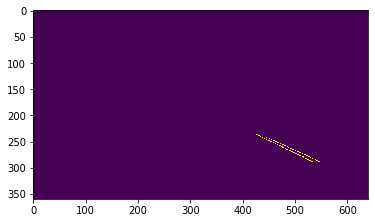

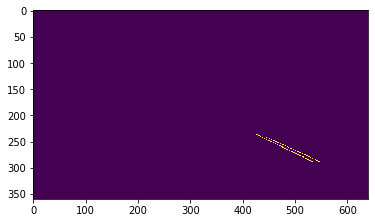

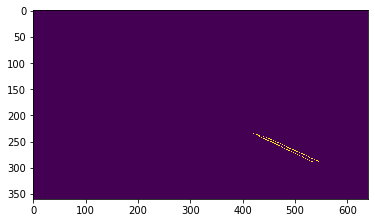

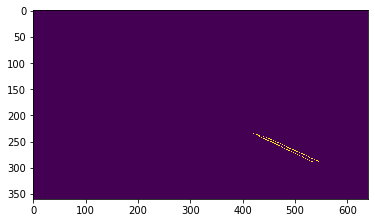

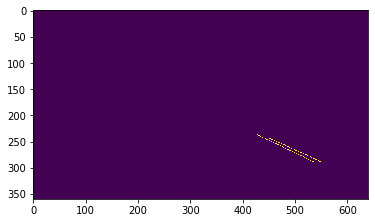

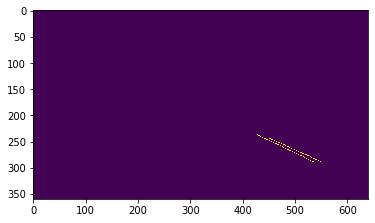

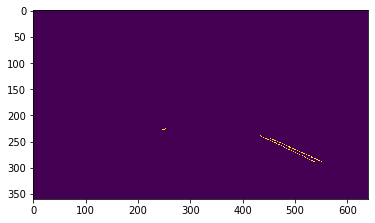

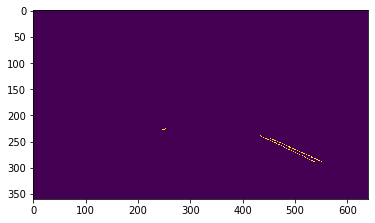

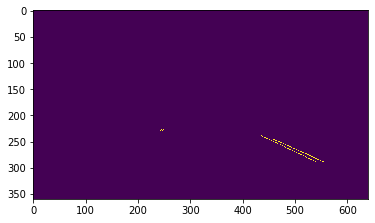

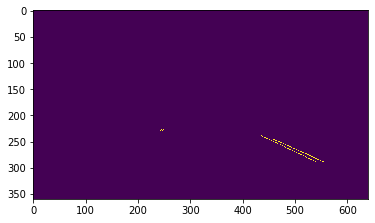

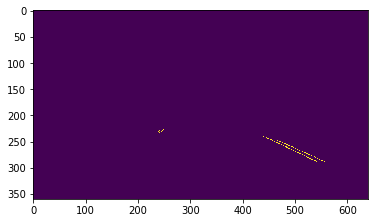

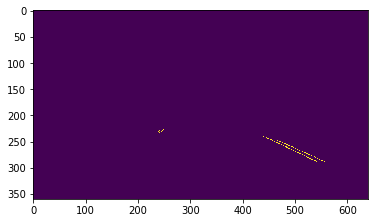

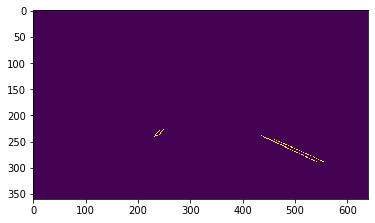

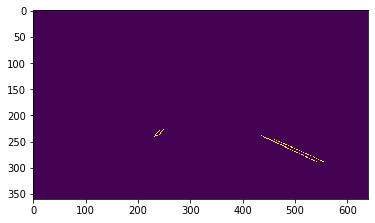

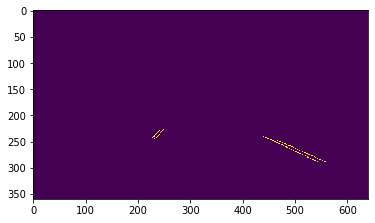

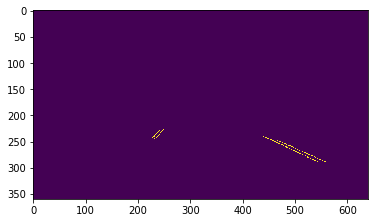

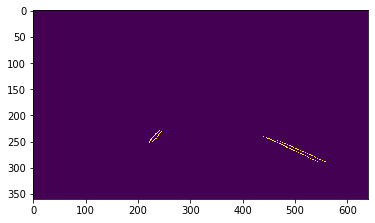

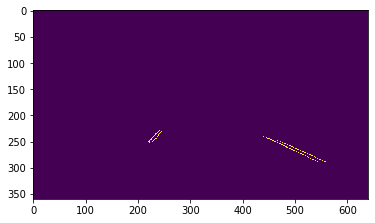

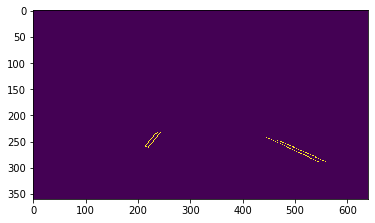

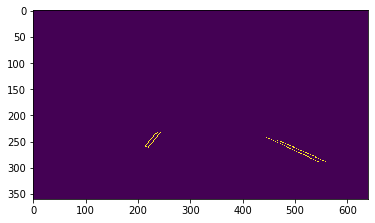

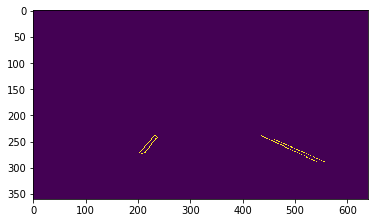

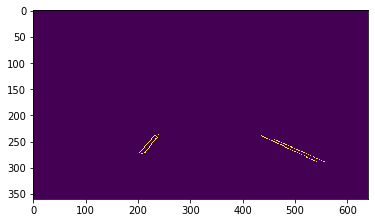

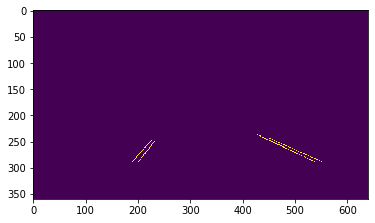

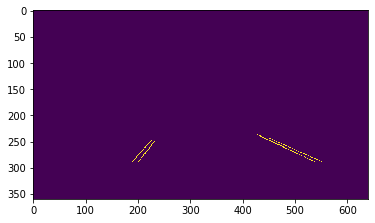

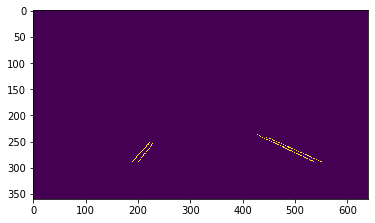

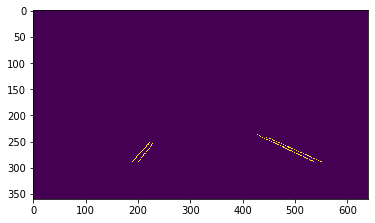

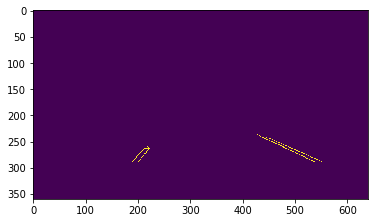

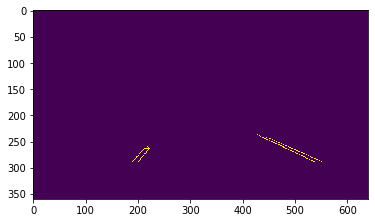

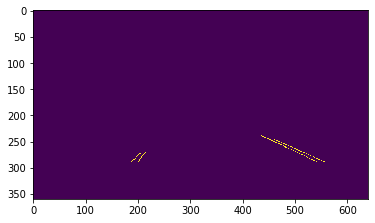

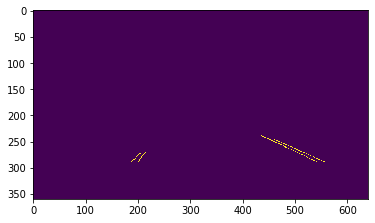

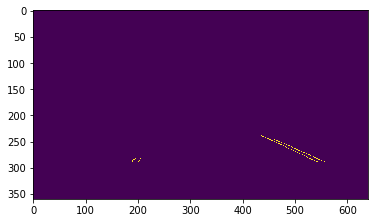

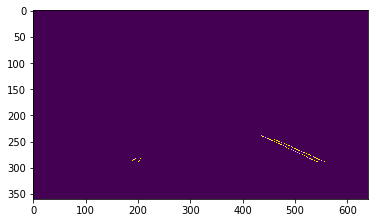

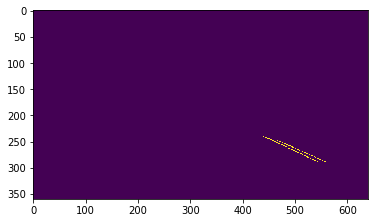

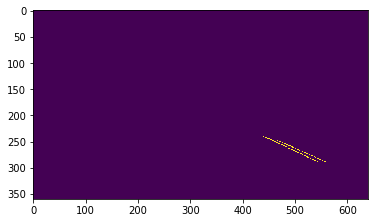

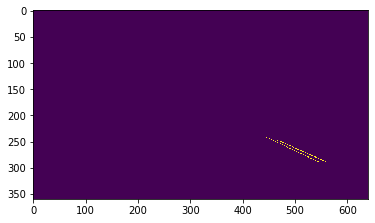

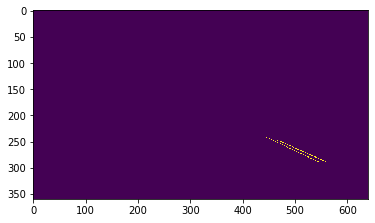

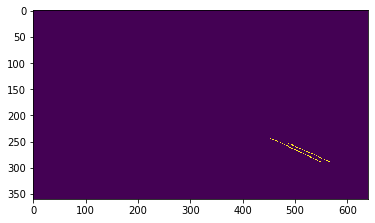

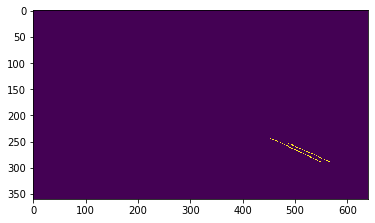

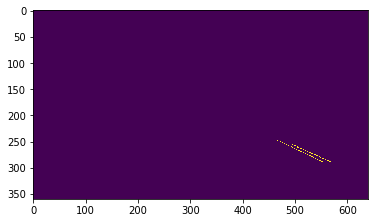

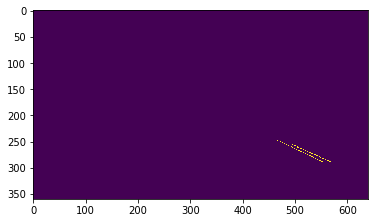

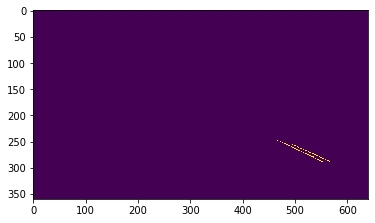

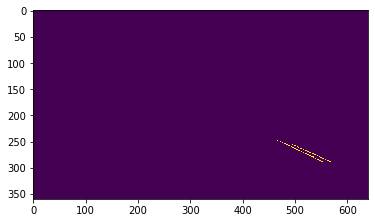

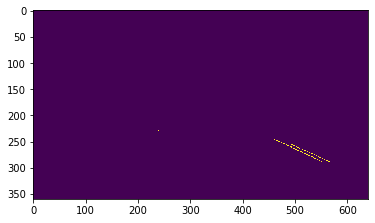

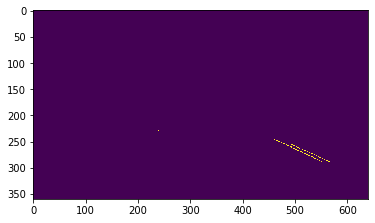

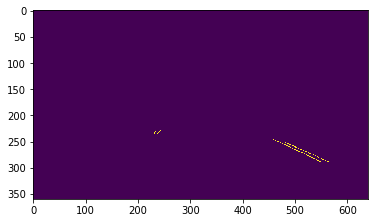

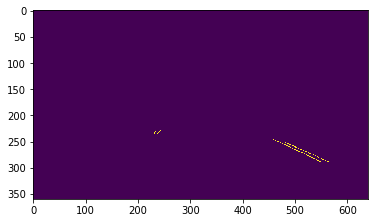

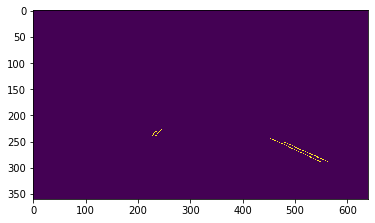

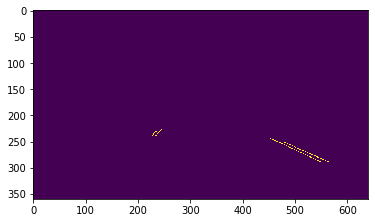

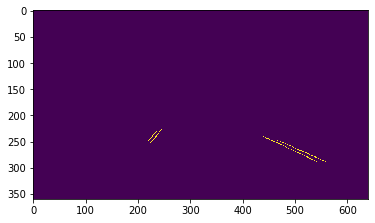

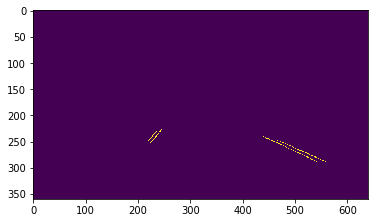

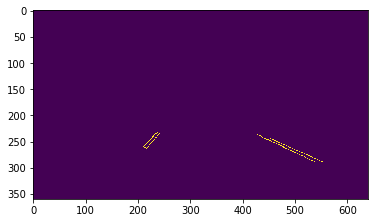

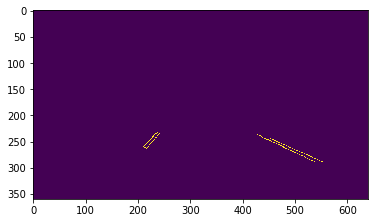

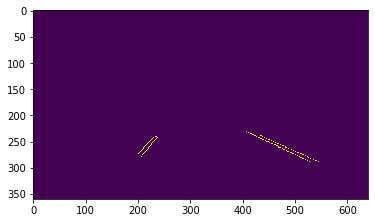

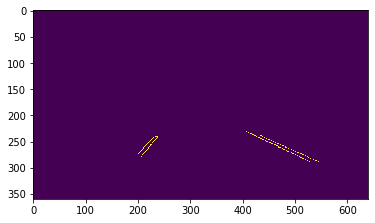

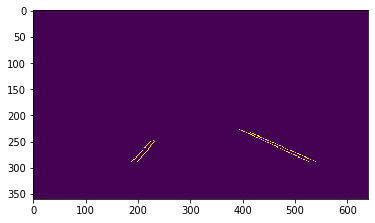

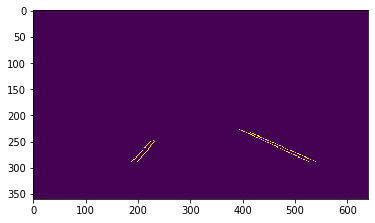

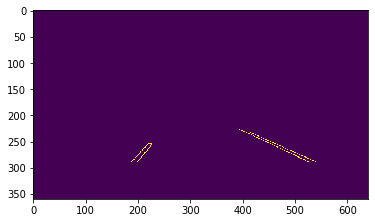

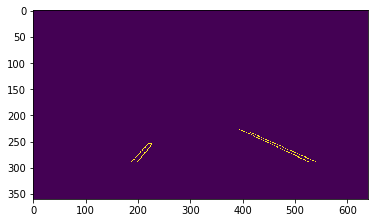

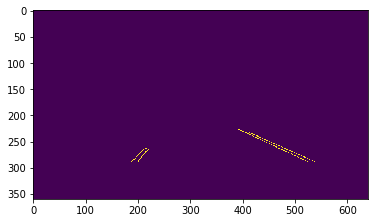

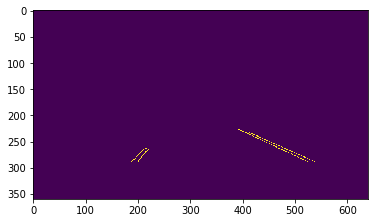

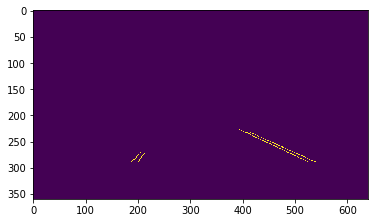

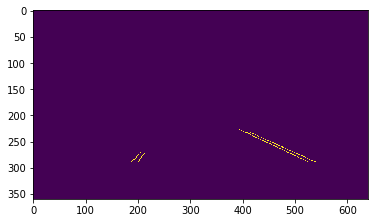

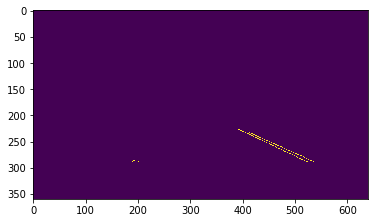

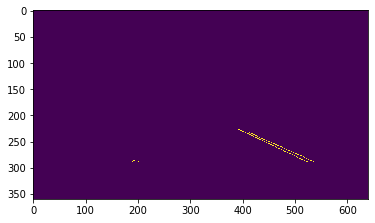

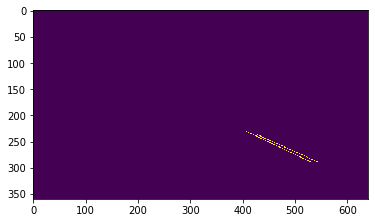

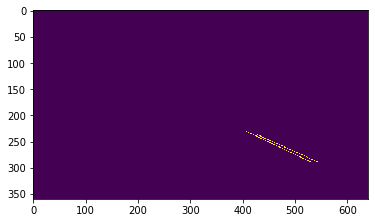

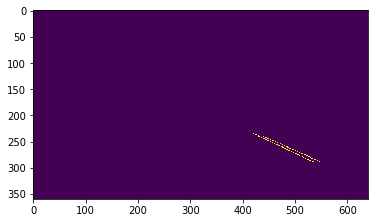

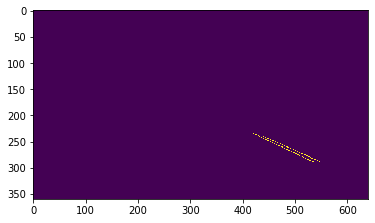

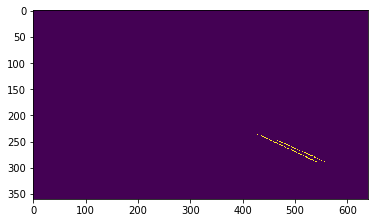

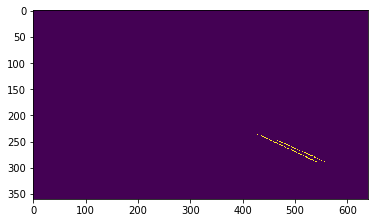

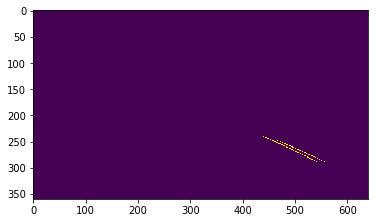

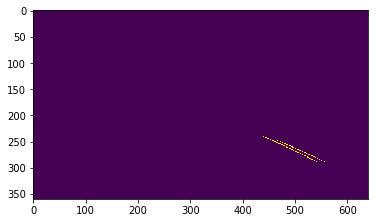

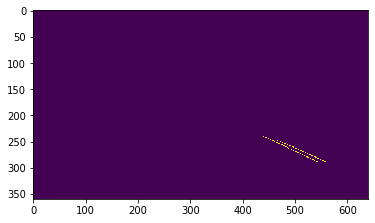

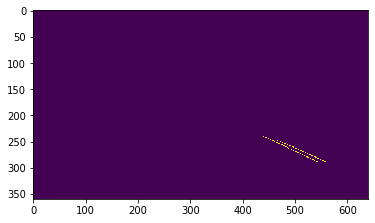

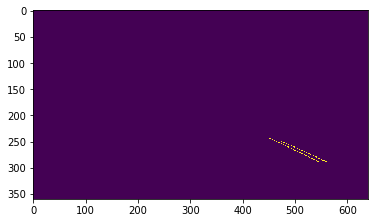

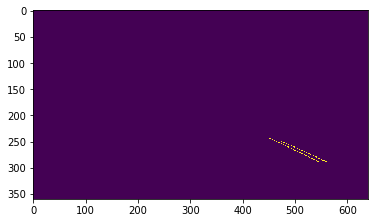

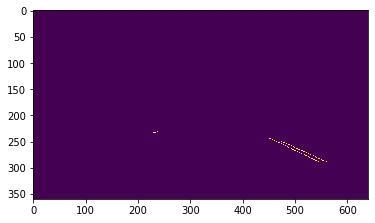

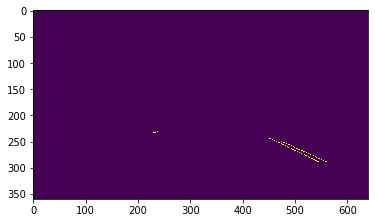

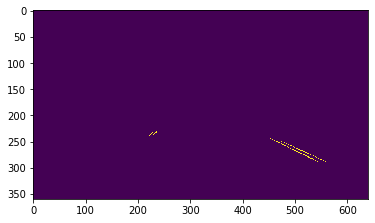

<Figure size 432x288 with 0 Axes>

In [4]:
white_output = 'driving_with_lanes_marked.mp4'
clip1 = VideoFileClip("Driving - 800.mp4").subclip(2,12)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [5]:
HTML("""
<video width="640" height="480" controls>
  <source src="{0}">
</video>
""".format(white_output))